In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

228668
C:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(10):
    plt.close()

In [3]:
# ------------------------------------------------------------
# --- FUNCTIONS ---
# ------------------------------------------------------------
from scipy.linalg import expm
from scipy.integrate import RK45
mix.reload_module(mix)

def case_Hermitian():
    print("--- Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


def case_non_Hermitian():
    print("--- NON-Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1 - 0.1j
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


# input: Hi = i*H:
def ref_computation(Hi, psi_init):
    def calc_y(t,y):
        y = -Hi.dot(y) 
        return y
    
    psi_out = np.zeros((Nt_,2), dtype=complex)
    psi_out[0,0] = psi_init[0]
    psi_out[0,1] = psi_init[1]
    
    oo = RK45(calc_y, t_[0], psi_out[0,:], t_[-1], first_step=dt_, max_step=dt_)
    Nt_act = 0
    oo.step() # skip one time step
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        psi_out[Nt_act,:] = oo.y
    print()
    print("--- refence computation ---")
    print("sum psi[RK-max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_out[Nt_act,:])**2)))
    return psi_out


def comp_LCHS_weights():
    wk = np.zeros(Nk_)
    for ik in range(Nk_):
        wk[ik] = 1. / (1 + k_[ik]*k_[ik])
    wk = wk * dk_/np.pi
    wk[0]  = 0.5 * wk[0]
    wk[-1] = 0.5 * wk[-1]  
    return wk


def comp_LCHS_weights_theta(d_theta):
    wk = np.zeros(Nk_)
    for ik in range(Nk_):
        wk[ik] = d_theta
    wk = wk /np.pi
    wk[0]  = 0.5 * wk[0]
    wk[-1] = 0.5 * wk[-1]  
    return wk
    

def analyse_exp_matrices(exp_1, exp_2):
    print("\n--- Exponentiation matrices ---")
    print(exp_1)
    print()
    print(exp_2)

    print("\n --- Difference between the matrix elements ---")
    abs_err_max = 0.0
    for ir in range(exp_1.shape[0]):
        for ic in range(exp_1.shape[1]):
            diff_comp = exp_1[ir,ic] - exp_2[ir,ic]
            abs_err = np.abs(diff_comp)
            if abs_err > abs_err_max:
                abs_err_max = abs_err
            print("[{:d},{:d}]: {:20.3e}".format(ir,ic, diff_comp))
    print()
    print("max. abs. error: {:0.3e}".format(abs_err_max))
    print("- log of max. abs. error: {:0.3f}".format(-np.log10(abs_err_max)))
    

def LCHS_computation(Hi, psi_init, Nt_loc, flag_trotterization, flag_print = False):
    # if flag_direct = False, use 2nd order Trotterization:
    Bh, Ba = get_herm_aherm_parts(Hi)
    wk = comp_LCHS_weights()
    
    exp_max = None
    if flag_trotterization:
        Prop_max = -1.j * dt_/2. * (Ba - k_max_*Bh)
        exp_max = expm(Prop_max)
        del Prop_max
    
    exp_LCHS = np.zeros((2,2), dtype=complex)
    for ik in range(Nk_):
        temp = np.identity(2, dtype=complex)
        
        exp_dt = None
        if not flag_trotterization:
            Prop_k = -1.j * dt_ * (Ba + k_[ik]*Bh) # here, use Trotterization
            exp_dt = expm(Prop_k)
        else:
            Prop_k = -1.j * dt_ * (ik * dk_) * Bh
            exp_dt = expm(Prop_k).dot(exp_max)
            exp_dt = exp_max.dot(exp_dt)
            
        for it in range(Nt_loc):
            temp = exp_dt.dot(temp)
        exp_LCHS += wk[ik] * temp
    del temp, Prop_k, exp_max, exp_dt, ik
         
    # compare the exponentiating matrices:
    if flag_print:
        exp_ref = np.identity(2, dtype=complex)
        exp_dt  = expm(-dt_*Hi)
        for it in range(Nt_loc):
            exp_ref = exp_dt.dot(exp_ref)
        del exp_dt
    
        analyse_exp_matrices(exp_ref, exp_LCHS)
        del exp_ref
        
    # compute the output quantum state:
    psi_t = exp_LCHS.dot(psi_init)
    
    if flag_print:
        print()
        print("sum psi_t_max[max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_t)**2)))
    return psi_t



def LCHS_computation_opt2(Hi, psi_init, Nt_loc, flag_print = False):
    # Use the following transformation: k = tg(theta)

    # print("here")
    
    Bh, Ba = get_herm_aherm_parts(Hi)
    
    theta_max = np.arctan(k_max_)
    theta = np.linspace(-theta_max, theta_max, Nk_)
    
    wk = comp_LCHS_weights_theta(np.diff(theta)[0])
    
    exp_LCHS = np.zeros((2,2), dtype=complex)
    for i_theta in range(Nk_):
        temp = np.identity(2, dtype=complex)
        
        exp_dt = None
        Prop_k = -1.j * dt_ * (Ba + np.tan(theta[i_theta])*Bh) # here, use Trotterization
        exp_dt = expm(Prop_k)

        for it in range(Nt_loc):
            temp = exp_dt.dot(temp)
        exp_LCHS += wk[i_theta] * temp
    del temp, Prop_k, exp_dt, i_theta
             
    # compute the output quantum state:
    psi_t = exp_LCHS.dot(psi_init)
    
    if flag_print:
        print()
        print("sum psi_t_max[max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_t)**2)))
    return psi_t




def compare_plots(psi_ref, psi_LCHS, id_var):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # --- REAL PART ---
    ax.plot(t_,      psi_ref.real[:,id_var],  "-b", linewidth = 2, label="ref")
    ax.plot(t_plot_, psi_LCHS.real[:,id_var], 
        "r", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="LCHS"
    )
    plt.xlabel('$t$')
    plt.ylabel("Re: " + "var[{:d}]".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- IMAG PART ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t_,      psi_ref.imag[:,id_var],  "-b", linewidth = 2, label="ref")
    ax.plot(t_plot_, psi_LCHS.imag[:,id_var], 
        "r", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="LCHS"
    )
    # plt.xlim([0,2])
    plt.xlabel('$t$')
    plt.ylabel("Im: " + "var[{:d}]".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()
    return


def plot_one_sim(t, psi):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    ax.plot(t, psi.real[:,0], "-b", linewidth = 2, label="Re var1")
    ax.plot(t, psi.real[:,1], "-r", linewidth = 2, label="Re var2")
    ax.plot(t, psi.imag[:,0], "--b", linewidth = 2, label="Im var1")
    ax.plot(t, psi.imag[:,1], "--r", linewidth = 2, label="Im var2")
    plt.xlabel('$t$')
    plt.ylabel("psi")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
    
    
# ----------------------------------------------------------------------------------
# --- Supplemental functions ---
# ----------------------------------------------------------------------------------
def h_adj(AA):
    return np.transpose(np.conjugate(AA))

def get_herm_aherm_parts(B):
    Bh = (B + h_adj(B)) / 2.
    Ba = (B - h_adj(B)) / (2.j)
    # B_ch = Bh + 1j * Ba
    return Bh, Ba

In [4]:
# --------------------------------------------
# --- LCHS computation ---
# --------------------------------------------

flag_trotterization = True
flag_theta = True

nt_          = 11
t_max_       = 12
diff_nt_plot = 6
nk_    = 10
k_max_ = 100

# time grid:
Nt_    = 1 << nt_
t_     = np.linspace(0, t_max_, Nt_)
dt_    = np.diff(t_)[0]

diff_N_ = 1 << diff_nt_plot
N_plot  = 1 << (nt_ - diff_nt_plot)

t_plot_ = np.zeros(N_plot)
for it in range(N_plot):
    t_plot_[it] = it * diff_N_ * dt_
del it

# k-grid for the LCHS:
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# initial state:
psi_init = np.zeros(2, dtype = complex)
psi_init[0] = np.sqrt(0.4)
psi_init[1] = np.sqrt(0.6)

# choose the matrix:
# Hi = case_Hermitian()
Hi = case_non_Hermitian()

# reference computation:
psi_ref = ref_computation(Hi, psi_init)

# LCHS computation:
if flag_trotterization:
    print("Performing LCHS computation (with trotterization)...")
else:
    print("Performing LCHS computation (without trotterization)...")
if flag_theta:
    print("\t[theta-weights]")
else:
    print("\t[k-weights]")

psi_LCHS = np.zeros((N_plot, 2), dtype = complex)
for it in range(N_plot):
    id_t = it * diff_N_  
    if flag_theta:
        psi_LCHS[it,:] = LCHS_computation_opt2(Hi, psi_init, id_t)
    else:
        psi_LCHS[it,:] = LCHS_computation(Hi, psi_init, id_t, flag_trotterization, flag_print = False)
del id_t, it
print("Done.")

del Hi, diff_nt_plot, N_plot, psi_init

--- NON-Hermitian Hamiltonian ---

*** Original Hamiltonian (without mult. by i)***
--- 0 ---
 1.000-0.100j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j

--- refence computation ---
sum psi[RK-max-time]**2: 3.004e-01
Performing LCHS computation (with trotterization)...
	[theta-weights]
Done.


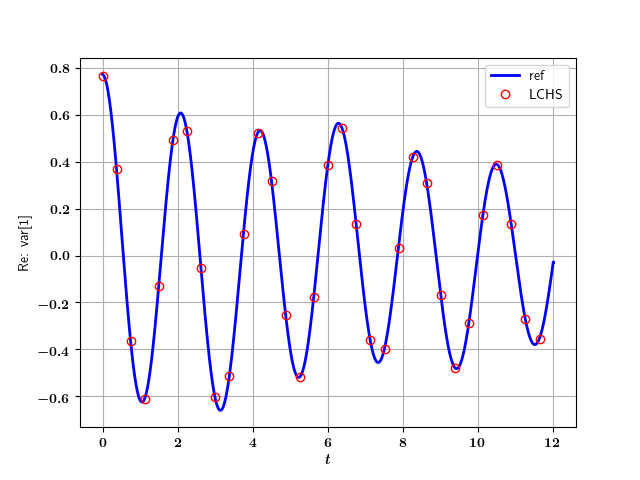

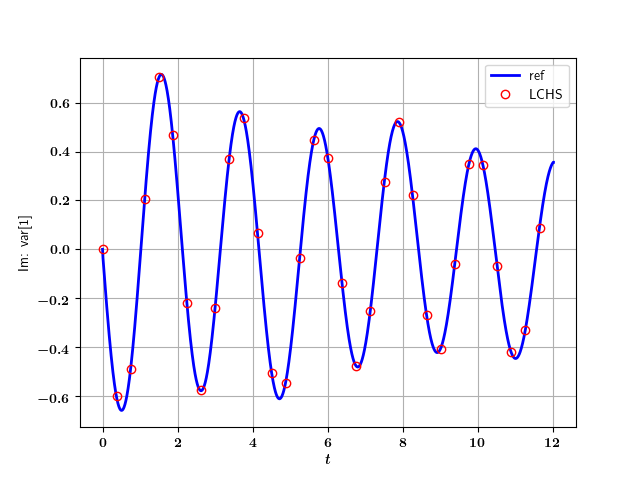

max. abs. err: 1.550e-02


In [6]:
# ----------------------------------------------------------
# --- Plot results ---
# ----------------------------------------------------------
compare_plots(psi_ref, psi_LCHS, id_var = 1)

max_abs_err = 0
for it in range(len(t_plot_)):
    err = np.max(np.abs(psi_ref[it * diff_N_] - psi_LCHS[it]))
    if max_abs_err < err:
        max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))
del max_abs_err, err , it

In [ ]:
# 1/err is linear with k_max
# nt = 12
# k_max:              10,        20,        40,       400,
# err(opt-k):  4.926e-02, 2.542e-02, 1.391e-02,
# err(opt-th): 4.926e-02, 2.542e-02, 1.391e-02, 3.434e-03,

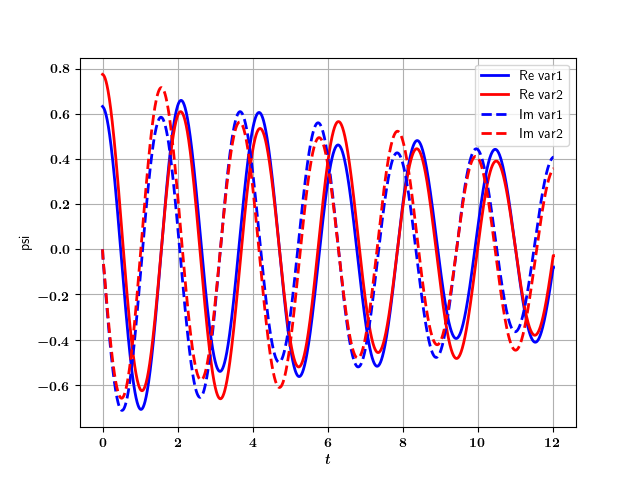

In [7]:
# ----------------------------------------------------
# --- Plot just the reference simulation ---
# ----------------------------------------------------
plot_one_sim(t_, psi_ref)

In [ ]:
# LCHS scaling (without trotterization) for a Hermitian matrix [[1, 2] [2, 1]]:
k_max_array =  [   10,    10,    10,    20,    20,   100,   200,  1600,  3200]
nk_array    =  [    4,     5,     7,     7,     8,     9,    10,    13,    14]
mlog_err    = -[1.089, 1.197, 1.198, 1.498, 1.498, 2.196, 2.497, 3.400, 3.701]

In [8]:
np.arctan(-1000)

-1.5697963271282296

In [9]:
np.arctan(1000)

1.5697963271282296